# Y-Branches

Y-branches are some of the most common types of photonic devices and are used in almost every photonic circuit. They are used to either split light into two waveguides or to combine light from two waveguides into one. While y-branches can be created that split light into any arbitrary fraction, in this page we will focus on a 50/50 y-branch. 

<div style="text-align: center;">

<image src="https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/y_branch_with_s_bend.png" alt="y_branch" width=100% height=100% title="Default gdsfactory Y Branch">
</div>

<p style="text-align: center;"> A y-branch from gdsfactory's default component library </p>

## Splitting Light

A 50-50 y-branch (the most common ratio) splits light evenly from the input waveguide into the two output waveguides. In other words, for an input intensity $I_i$ and output intensities $I_1$ and $I_2$
$$ I_1=I_2=I_i/2$$
However, no y-branch is perfect and so there will always be loss. Thus, in a 50/50 splitter, the actual outputs will be slightly less than 50, but should still be equal if we ignore manufacturing variability. There are y-branches that are designed to split light in different ratios, e.g. 70/30, 90/10, and those have different shapes.

<div style="text-align: center;">

<image src="https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/split_light.png" alt="y_branch" width=75% height=75% title="Splitting Light between two branches">
</div>

The above image shows light from the left side being split evenly between the two output waveguides on the right. We can also see that there is light leaking out of the y-branch into the cladding. The light in the outputs also looks different from the light in the input because the light is now split between the fundamental mode (like the input) and higher order modes. The part of the light in higher order modes is often just considered "lost" since many photonic circuits assume that all the light is in the fundamental mode.


### Combining Light

Recombining light with y-branches is more complicated than one might expect based on intuition. The behavior of electromagnetic fields in linear optical media is symmetric in time, which means that if we change the outputs to be inputs and vice-versa, then we get the exact same response. Therefore, in order to get perfect combination of light into the fundamental mode, we need to have both branches on the right side to have input light with the same phase. Then the light from the two branches constructively interferes and all the light ends up in the fundamental mode.

<div style="text-align: center;">
<image src="https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/ybranch_combining_inphase.png" alt="y_branch" width=75% height=75% title="In phase combination of light in y-branch">
</div>

When the light is completely out of phase, none of the light couples into the fundamental mode because of destructive interference.

<div style="text-align: center;">
<image src="https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/ybranch_combining_outofphase.png" alt="y_branch" width=75% height=75% title="Out of phase combination of light in y-branch">
</div>

When you input light from only one branch, some of the light couples into the fundamental mode (0th order) and some into the 1st order mode, and some back-reflections into the second input branch. If you look at this from the time reversal perspective, if the y-branch is a 50-50 splitter, you can't just have light in the fundamental mode coming from the input if you want the light to all go into a single output branch because the y-branch will split the light 50-50. However, if you introduce a higher order mode, you can now create interference that ensures most of the light goes into a single output. Which output that is is determined by the relative phase of the two modes.

<div style="text-align: center;">
<image src="https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/single_source_combine.png" alt="y_branch" width=75% height=75% title="Fundamental and 1st order mode mixed at output">
</div>

The above image shows light coming from the upper right arm being split between the fundamental and 1st order modes in the left waveguide. There is also significant reflections going into the lower right waveguide.


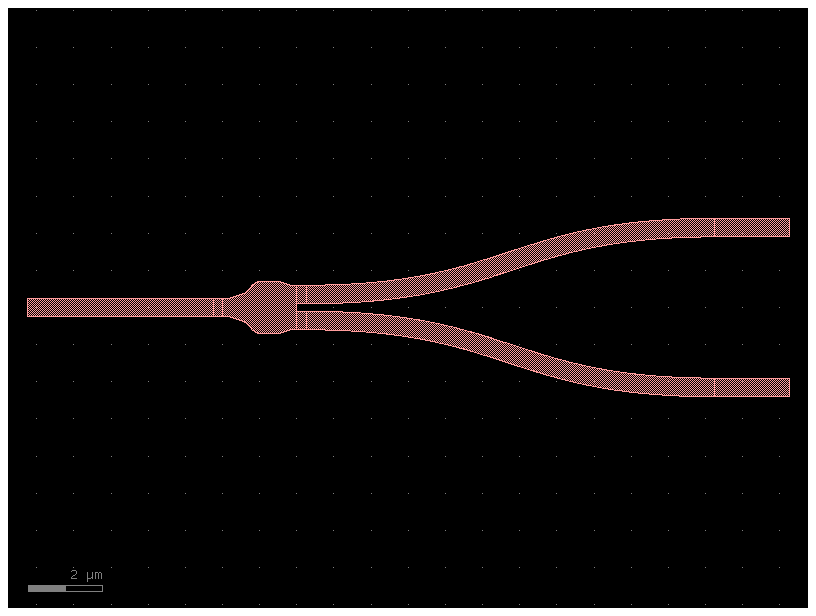

In [71]:
import gdsfactory as gf

ybranch = gf.Component("Y-branch")

inwg = gf.components.straight(length=5, layer=(1,0))
outwg = gf.components.straight(length=2, layer=(1,0))
splitter = gf.components.mmi1x2_with_sbend()

inwg_ref = ybranch.add_ref(inwg)
splitter_ref = ybranch.add_ref(splitter)
outwg_top_ref = ybranch.add_ref(outwg)
outwg_bot_ref = ybranch.add_ref(outwg)

inwg_ref.connect(port="o2", destination=splitter_ref.ports["o1"])
outwg_top_ref.connect(port="o1", destination=splitter_ref.ports["o2"])
outwg_bot_ref.connect(port="o1", destination=splitter_ref.ports["o3"])
ybranch.plot()

filename = 'out/ybranch.gds'

In [72]:
import meep as mp
import matplotlib.pyplot as plt
mp.verbosity(0)

def make_geometry_from_gds_component(component:gf.Component, resolution=40, core_mat=mp.Medium(index=3.45), cladding_mat=mp.Medium(index=1.45)):

    component_points = component.to_np(1e3/resolution, pad_width=0)
    Nx = component_points.shape[0]
    Ny = component_points.shape[1]
    sx = Nx / resolution
    sy = Ny / resolution

    matgrid = mp.MaterialGrid(mp.Vector3(Nx,Ny,0),
                            cladding_mat,
                            core_mat,
                            weights=component_points,
                            beta=0,
                            do_averaging=True,
                            damping=0)
    geometry = [mp.Block(center=mp.Vector3(), size=mp.Vector3(sx,sy,0), material=matgrid)]
    
    return geometry

In [ ]:
resolution = 40
geometry = make_geometry_from_gds_component(ybranch, resolution=resolution)

sources = [mp.EigenModeSource(mp.ContinuousSource(frequency=1/1.55),
                              volume=mp.Volume(center=mp.Vector3(x=8, y=2.2), size=mp.Vector3(y=2)),
                              direction=-mp.X,
                              eig_band=1,
                              component=mp.Ez),
           mp.EigenModeSource(mp.ContinuousSource(frequency=1/1.55),
                              volume=mp.Volume(center=mp.Vector3(x=8, y=-2.2), size=mp.Vector3(y=2)),
                              direction=-mp.X,
                              eig_band=1,
                              component=mp.Ez,
                              amplitude=-1)]

boundary_layers = [mp.PML(1.5)]

cell_size = geometry[0].size + mp.Vector3(y=5)

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    default_material=mp.Medium(index=1.45))

dft = sim.add_dft_fields([mp.Ez], 1/1.55, 0.01, 3, where=mp.Volume(size=cell_size - mp.Vector3(3, 3)))

sim.plot2D()
sim.run(until=70)

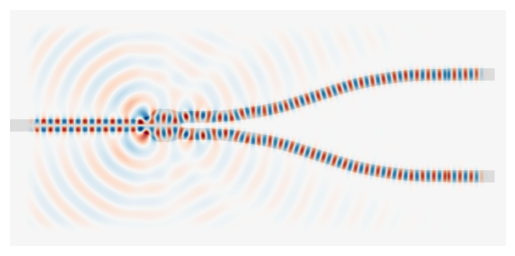

In [82]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Dielectric)
e_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(e_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

#### Design Considerations

Directional couplers and y-branches both can be used to split and recombine light. Here are some things to consider when making design choices for splitters/combiners.

- Size: Y-branches are significantly more compact than standard directional couplers. This is very significant in large circuits.
- Loss: Directional couplers have less loss since they don't have reflections and multimode regions.
- Splitting Ratio: Directional couplers lengths/gaps can be adjusted for arbitrary splitting ratios easily while y-branches' shape must be optimized for each case, making directional couplers easier to design.
- Manufacturing Variability: Due to the larger scale of directional couplers, they are more likely to be affected by fab variance.

#### Practice

<details>
    <summary>Answer</summary>
    Here is the answer  
</details>

#### Sources

"Silicon Photonics Design" by Lukas Chrostowski